# Diabetic Retinopathy Image Detection

## Preprocessing steps (inspired by Francois Chollet's deep learning with Python book):
1. Create a data folder and training and validation folders within it. Within the training and validation folders, 
   create positive and negative folders that contain image files belonging to either the positive or negative class so
   the directory looks like so:
   
   data/
       training/
           positive/
           negative/
       validation/
           positive/
           negative/

2. Use keras' builtin ImageDataGenerator to augment the data through rotation, shifting, and flipping the images.

3. Use the ImageDataGenerator to do the following to the picture files:
    * Read the picture files.
    * Decode the JPEG content to RGB grids of pixels.
    * Convert these into floating-point tensors.
    * Rescale the pixel values (between 0 and 255) to the [0, 1] interval.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [2]:
!pwd

/kaggle/working


In [3]:
!ls /kaggle/input/train_images/ | head -5

000c1434d8d7.png
001639a390f0.png
0024cdab0c1e.png
002c21358ce6.png
005b95c28852.png
ls: write error: Broken pipe


In [4]:
import numpy as np 
import pandas as pd

import os

from PIL import Image

import matplotlib.pyplot as plt 
import matplotlib.image as img

from keras import layers
from keras import models
from keras import optimizers

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from shutil import copyfile, rmtree

Using TensorFlow backend.


In [5]:
# Input data files are available in the "../input/" directory.
print(os.listdir("../input"))

['sample_submission.csv', 'test_images', 'train_images', 'test.csv', 'train.csv']


In [6]:
#pd.read_csv('../input/train.csv').shape  3662 * 2
#pd.read_csv('../input/test.csv').shape # 1928 * 1

In [7]:
print(os.listdir('../input/train_images')[:10])

['42b9c1977681.png', '840527bc6628.png', '12e3f5f2cb17.png', '435d900fa7b2.png', 'ff1e940105f9.png', '527bea76116c.png', 'ef8c39eb9157.png', '737ef6226677.png', 'f583a722434c.png', 'b2ffa3e18559.png']


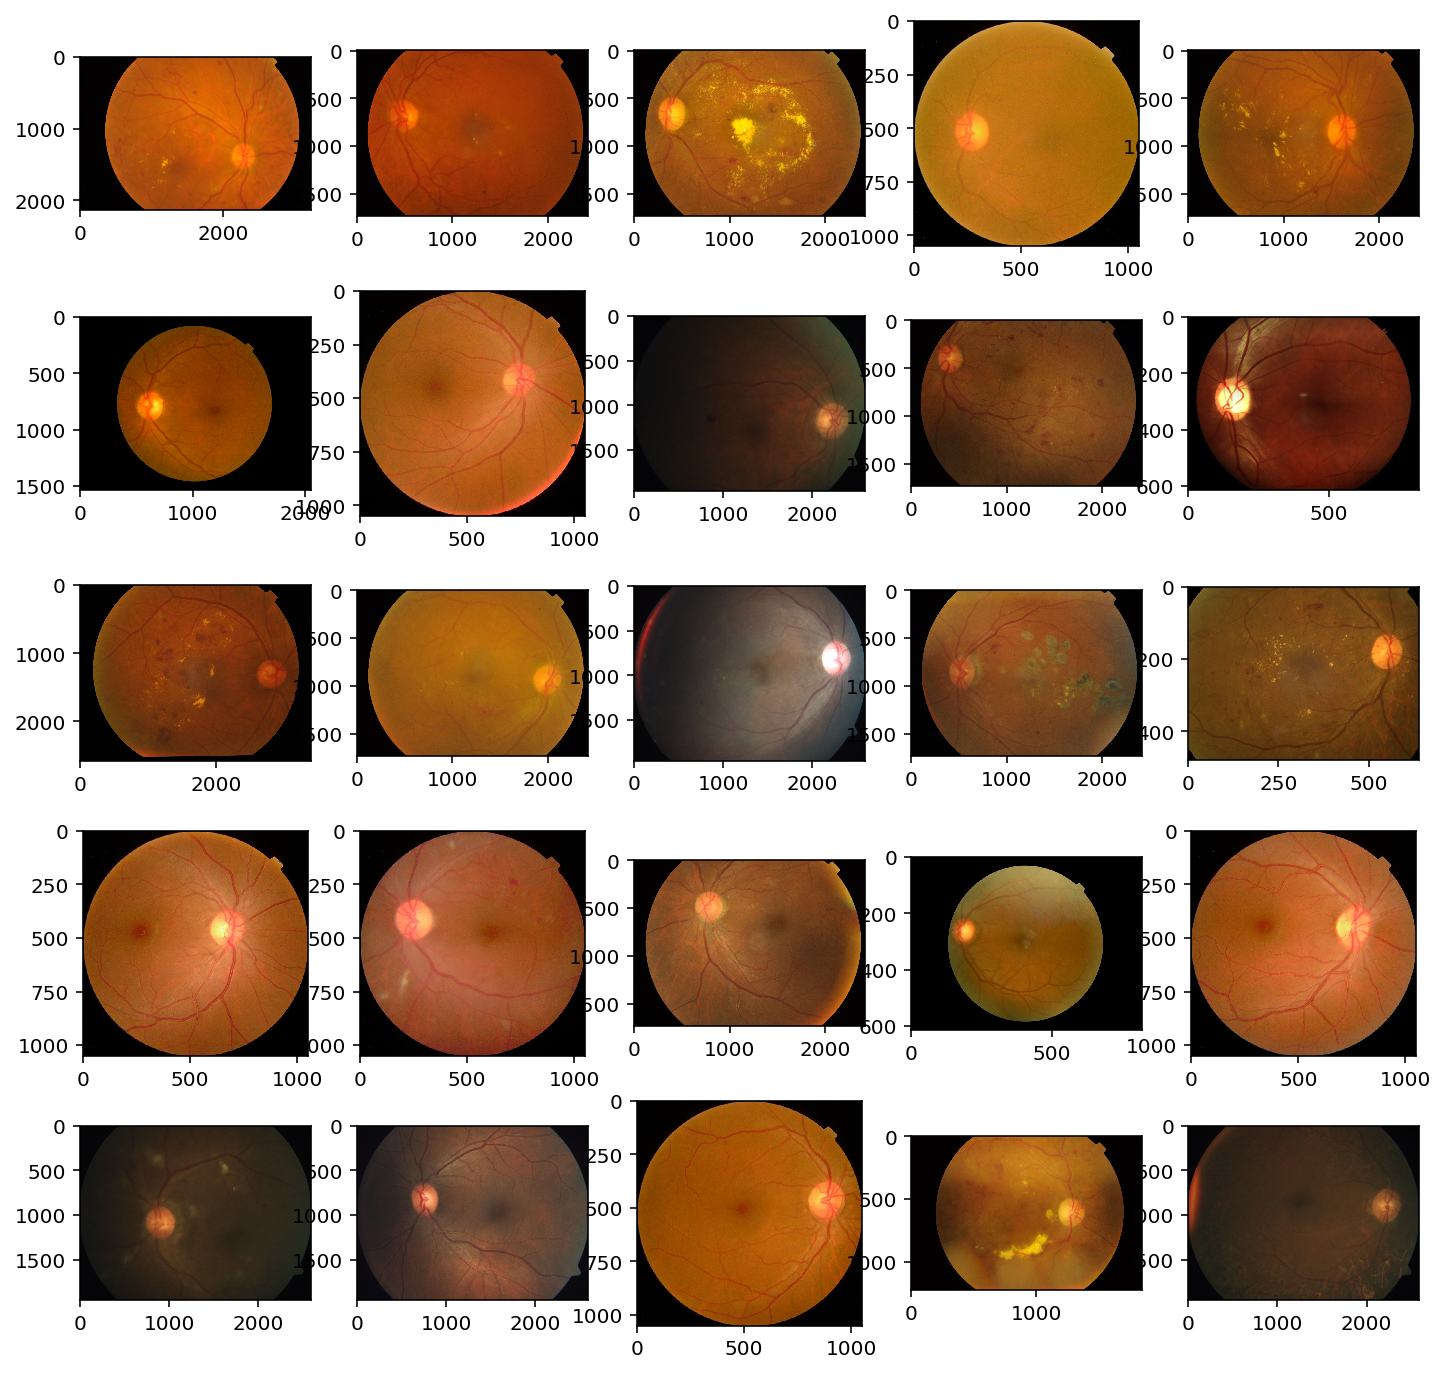

In [8]:
image_file_list = os.listdir('../input/train_images')[:50]

w=10
h=10
fig=plt.figure(figsize=(12, 12))
columns = 5
rows = 5

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    image_filename = image_file_list[i]
    image_path = os.path.join('../input/train_images',image_filename)
    image = img.imread(image_path) 
    plt.imshow(image)
plt.show()

### Diagnosis codes:
0. No DR
1. Mild
2. Moderate
3. Severe
4. Proliferative DR

In [9]:
train = pd.read_csv('../input/train.csv')
train.shape
train.head()

(3662, 2)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [10]:
train.groupby('diagnosis').count()
train.groupby('diagnosis').id_code.nunique()

,id_code
diagnosis,
0,1805
1,370
2,999
3,193
4,295


diagnosis
0    1805
1     370
2     999
3     193
4     295
Name: id_code, dtype: int64

In [11]:
pd.read_csv('../input/test.csv', nrows=5)

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


## Define model

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [13]:
model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=['acc'])

## Begin image preprocessing

### Create a training data directory and validation data directory containing one subdirectory per image class

In [14]:
os.listdir('../')

['working', 'lib', 'src', 'input']

In [15]:
# os.mkdir('../train_data')
# os.mkdir('../train_data/positives')
# os.mkdir('../train_data/negatives')

# Remove a FULL directory (using shutil):
#rmtree('../train_data/')



#os.mkdir('../data')
os.mkdir('../data/train')
os.mkdir('../data/validation')
os.mkdir('../data/train/positives')
os.mkdir('../data/train/negatives')
os.mkdir('../data/validation/positives')
os.mkdir('../data/validation/negatives')


os.listdir('../') #['config', 'data', 'working', 'lib', 'input']

os.listdir('../data/') # ['validation', 'train']

os.listdir('../data/') # ['positives', 'negatives']

FileNotFoundError: [Errno 2] No such file or directory: '../data/train'

In [16]:
positives = train[train['diagnosis'] != 0]
negatives = train[train['diagnosis'] == 0]

positives.shape
negatives.shape

positives.head()
negatives.head()

positive_filenames = list(positives.id_code + '.png')
negative_filenames = list(negatives.id_code + '.png')

positive_filenames[:5]
negative_filenames[:5]

(1857, 2)

(1805, 2)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
5,0083ee8054ee,4
7,00a8624548a9,2


,id_code,diagnosis
3,002c21358ce6,0
4,005b95c28852,0
6,0097f532ac9f,0
10,00cc2b75cddd,0
12,00f6c1be5a33,0


['000c1434d8d7.png',
 '001639a390f0.png',
 '0024cdab0c1e.png',
 '0083ee8054ee.png',
 '00a8624548a9.png']

['002c21358ce6.png',
 '005b95c28852.png',
 '0097f532ac9f.png',
 '00cc2b75cddd.png',
 '00f6c1be5a33.png']

In [17]:
positive_filenames.__len__() # 1857
negative_filenames.__len__() # 1805

1857

1805

## Split into train/validation:

In [18]:
positive_filenames_train = np.random.choice(positive_filenames, int(len(positive_filenames)*0.8))
positive_filenames_train

positive_filenames_validation = [x for x in positive_filenames if x not in positive_filenames_train]
positive_filenames_validation[:10]

array(['80964d8e0863.png', 'e599151ca14b.png', 'dd19428c3d29.png', ...,
       '6f4e0538d1e4.png', '50a2aef380c8.png', '3128eb593012.png'],
      dtype='<U16')

['000c1434d8d7.png',
 '001639a390f0.png',
 '0024cdab0c1e.png',
 '0083ee8054ee.png',
 '00e4ddff966a.png',
 '01b3aed3ed4c.png',
 '01c7808d901d.png',
 '01eb826f6467.png',
 '025a169a0bb0.png',
 '026dcd9af143.png']

In [19]:
negative_filenames_train = np.random.choice(negative_filenames, int(len(negative_filenames)*0.8))
negative_filenames_train

negative_filenames_validation = [x for x in negative_filenames if x not in negative_filenames_train]
negative_filenames_validation[:10]

array(['d866c26d76f0.png', 'd436c06f0490.png', '2209daf71aab.png', ...,
       '91f3c4c1e72b.png', '07596907347b.png', 'c4aef0d88d1b.png'],
      dtype='<U16')

['005b95c28852.png',
 '0097f532ac9f.png',
 '0151781fe50b.png',
 '0231642cf1c2.png',
 '02358b47ea89.png',
 '02da652c74b8.png',
 '0423237770a7.png',
 '04aef84a2cc1.png',
 '05113073b268.png',
 '05339950962e.png']

In [20]:
# If images from the training set are positively diagnosed as diabetic retinopathy, move them to the 'positives' directory. 
# Otherwise, move them to the 'negatives' directory:

for file in os.listdir('../input/train_images/'):
    src = os.path.join('../input/train_images',file)
    if file in positive_filenames:
        if file in positive_filenames_train:
            dst = os.path.join('../data/train/positives',file)
            copyfile(src, dst)
        elif file in positive_filenames_validation:
            dst = os.path.join('../data/validation/positives',file)
            copyfile(src, dst)
    elif file in negative_filenames:
        if file in negative_filenames_train:
            dst = os.path.join('../data/train/negatives',file)
            copyfile(src, dst)
        elif file in negative_filenames_validation:
            dst = os.path.join('../data/validation/negatives',file)
            copyfile(src, dst)
    else:
        print(file,"not found in either list")

FileNotFoundError: [Errno 2] No such file or directory: '../data/train/negatives/42b9c1977681.png'

In [21]:
os.listdir('../data/train/positives/')[:10]
os.listdir('../data/train/negatives/')[:10]

FileNotFoundError: [Errno 2] No such file or directory: '../data/train/positives/'

In [22]:
os.listdir('../data/validation/positives/')[:10]
os.listdir('../data/validation/negatives/')[:10]

FileNotFoundError: [Errno 2] No such file or directory: '../data/validation/positives/'

## Now that the files are in the correct directory structure, we will define generator pipelines to feed the data to the model in a memory-efficient fashion:

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '../data/train/'
validation_dir = '../data/validation/'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150), # Resize images to same size
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

FileNotFoundError: [Errno 2] No such file or directory: '../data/train/'

In [24]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

NameError: name 'train_generator' is not defined

In [25]:
for data_batch, labels_batch in validation_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

NameError: name 'validation_generator' is not defined

## Training

In [26]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

NameError: name 'train_generator' is not defined

In [27]:
os.mkdir('../models/')
model.save('../models/retinopathy_detector_v1.h5')
os.listdir('../models')

['retinopathy_detector_v1.h5']

## Plot loss and accuracy curves during training

In [28]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined